In [1]:
import Flux
using Flux.Tracker, Statistics, DelimitedFiles
using Flux.Tracker: Params, gradient, update!
using Flux: gpu, Dense, relu, Chain, ADAM, RMSProp, Descent, params, throttle, Dropout, @epochs, testmode!

using Plots

using Base.Iterators: repeated

using DataFrames, DataFramesMeta, ExcelFiles, MLDataUtils, HDF5, ProgressMeter

using BSON: @save, @load
using NNlib

loaded


# DATA IMPORT

In [6]:
X_columns = h5read("./data/DataSet.hdf5", "X_columns")

X_entropy_train = h5read("./data/DataSet.hdf5", "X_entropy_train")
X_entropy_train_sc = h5read("./data/DataSet.hdf5", "X_entropy_train_sc")

X_entropy_valid = h5read("./data/DataSet.hdf5", "X_entropy_valid")
X_entropy_valid_sc = h5read("./data/DataSet.hdf5", "X_entropy_valid_sc")

X_entropy_test = h5read("./data/DataSet.hdf5", "X_entropy_test")
X_entropy_test_sc = h5read("./data/DataSet.hdf5", "X_entropy_test_sc")

X_entropy_sc_tv = [X_entropy_train_sc X_entropy_valid_sc]

X_tv = h5read("./data/DataSet.hdf5", "X_tv")
X_tv_sc = h5read("./data/DataSet.hdf5", "X_tv_sc")
y_tv = h5read("./data/DataSet.hdf5", "y_tv")

X_train = h5read("./data/DataSet.hdf5", "X_train")
X_train_sc = h5read("./data/DataSet.hdf5", "X_train_sc")
y_train = h5read("./data/DataSet.hdf5", "y_train")

X_valid = h5read("./data/DataSet.hdf5", "X_valid")
X_valid_sc = h5read("./data/DataSet.hdf5", "X_valid_sc")
y_valid = h5read("./data/DataSet.hdf5", "y_valid")

X_test = h5read("./data/DataSet.hdf5", "X_test")
X_test_sc = h5read("./data/DataSet.hdf5", "X_test_sc")
y_test = h5read("./data/DataSet.hdf5", "y_test")

X_scaler_mean = h5read("./data/DataSet.hdf5", "X_scaler_mean")
X_scaler_var = h5read("./data/DataSet.hdf5", "X_scaler_var")
println("loaded")
println("\nFeatures in X_ arrays are")
println(X_columns)
println("\nShape of X train and valid is")
println(size(X_tv))

loaded

Features in X_ arrays are
["sio2", "al2o3", "na2o", "k2o", "nbot", "ifsm", "ifst", "ap", "b", "T", "Sc", "tg", "ScT"]

Shape of X train and valid is
(13, 1145)


In [7]:
function prepare_datas(X_,y_)
    
    y = reshape(y_[:],1,length(y_))
    
    x = X_[1:4,:]
    ap = reshape(X_[8,:],1,size(X_,2))
    b = reshape(X_[9,:],1,size(X_,2))
    T = reshape(X_[10,:],1,size(X_,2))
    #be = reshape(X_[11,:],1,size(X_,2))
    sc = reshape(X_[11,:],1,size(X_,2))
    tg = reshape(X_[12,:],1,size(X_,2))
    return x, y, T, ap, b, sc, tg
end

function gkfolds(X_, y_, idx_label; k = 5)

    dd = kfolds(shuffleobs(unique(X_[idx_label,:])), k = k);
    
    out = []
    
    for j = 1:k
        train_lab, vald_lab = dd[j]
        train_idx = Int64[]
        valid_idx = Int64[]

        for i = 1:size(X_,2)
            if findall(X_[idx_label,i] .== train_lab) != []
                push!(train_idx, i)
            else
                push!(valid_idx, i)
            end
        end
        
        push!(out,((X_[:,train_idx],y_[train_idx]),(X_[:,valid_idx],y_[valid_idx])))
        
    end
    
    return out
end


gkfolds (generic function with 1 method)

In [8]:
nb_folds = 5
folds = gkfolds(X_train_sc,y_train,8,k=nb_folds);

folds_entropy = gkfolds(X_entropy_sc_tv,X_entropy_sc_tv[11,:],12,k=nb_folds);

# Model

In [22]:
# The model

#
# With two subnetworks for Be and Sc
#

function thousands(size)
    return ones(size).*log.(100000)
    end

function tens(size)
    return ones(size).*log(10)
end

function init_both(dims)
    return ones(dims).*[log.(100000.);log.(10.)]
end

nb_neurons = 100
p_drop = 0.5

c1 = Dense(4, nb_neurons, relu)
c2 = Dense(nb_neurons, nb_neurons, relu)
c3 = Dense(nb_neurons, nb_neurons, relu)
c4 = Dense(nb_neurons, nb_neurons, relu)
c5 = Dense(nb_neurons, nb_neurons, relu)
cout = Dense(nb_neurons, 2,initb=init_both)

m1 = Chain(
    c1, Dropout(p_drop),
    c2, Dropout(p_drop),
    c3, Dropout(p_drop),
    #c4, Dropout(p_drop),
    #c5, Dropout(p_drop),
    cout) # |> gpu

m1_decode = Chain(Dense(2,nb_neurons,relu), # COUT
    Dense(nb_neurons, nb_neurons, relu), #c3
    Dense(nb_neurons, nb_neurons, relu), # c2
    Dense(nb_neurons, 4, relu)) #c1

N = 32 # Size of the encoding
autoenc = gpu(Chain(m1, m1_decode))

loss_autoenc(x) = mse(m(x), x)
 
Be(x) = reshape(exp.(m1(x[1:4,:])[1,:]),1,size(x,2))
ScTg(x) = reshape(exp.(m1(x[1:4,:])[2,:]),1,size(x,2))

# Other stuffs

Ae = param([-2.11])

tg(x) = Be(x)./((12.0.-Ae).*ScTg(x))

dCp(x,T, ap, b) = ap.*(log.(T).-log.(tg(x))) .+ b.*(T.-tg(x))

model(x,T, ap, b) = Ae .+ Be(x) ./ (T.* (ScTg(x) .+ dCp(x,T, ap, b)))

mse(yp, y) = sqrt(sum((yp .- y).^2)./size(y, 2))
mse_weighted(yp, y, w) = sqrt(sum((yp .- y).^2.0./(w.^2))./size(y, 2))

predict(x,T, ap, b) = model(x,T, ap, b)

# loss functions

loss_n(x, T, ap, b, y_target) = mse(model(x, T, ap, b), y_target)

loss_sc(x,sc) = mse(ScTg(x),sc)

loss_tg(x,target) = mse(tg(x),target)

loss_tg_sc(x,tg_target,sc_target) = loss_tg(x,tg_target) .+ loss_sc(x,sc_target).*100.0

loss_global(x, T, ap, b, y_target, x2, tg2_target, sc2_target) = loss_n(x, T, ap, b, y_target) .+ loss_tg_sc(x2,tg2_target,sc2_target)


loss_global (generic function with 1 method)

# Pre-training

In [23]:
loss_autoenc(X_train_sc[1:4,:])
#Flux.train!(loss_autoenc, X_train_sc[1:4,:], opt)

1.9738159892274119 (tracked)

In [32]:
record_pretrain_train = []
record_pretrain_valid = []
evalcb = () -> (push!(record_pretrain_train, loss_autoenc(X_train_sc[1:4,:]).data),
            push!(record_pretrain_valid, loss_autoenc(X_train_sc[1:4,:]).data))
    
opt = ADAM(0.001)
for i = 1:1000
    Flux.train!(loss_autoenc, params(m1,m1_decode), [(X_train_sc[1:4,:],)], opt)
end


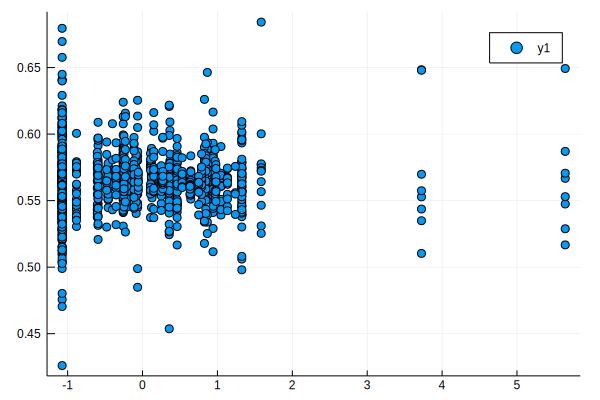

In [33]:
scatter(X_train_sc[2,:],autoenc(X_train_sc[1:4,:]).data[2,:])

# Training

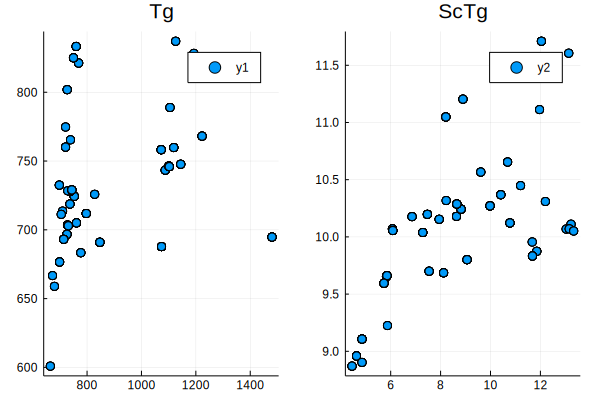

In [6]:
testmode!(m1)

scatter(([X_entropy_sc_tv[12,:],X_entropy_sc_tv[11,:]],
        [tg(X_entropy_sc_tv).data[:],ScTg(X_entropy_sc_tv).data[:]]),layout=2, 
    title=["Tg" "ScTg"])


In [30]:
# SC training
record_loss_sc_train = Float64[]
record_loss_sc_valid = Float64[]
record_loss_sc_tv = Float64[]

record_folds_train = Float64[]
record_folds_valid = Float64[]

record_loss_n_train = Float64[]
record_loss_n_valid = Float64[]


for alternance = 1:2
    
    testmode!(m1,false)
    epoch_idx = 1; optimal_epochs_s = 0; 
    early_stop = 1; patience = 20
    min_loss_val = 30000000.0
    
    p = ProgressMeter.Progress(patience, 1)   # minimum update interval: 1 second
    while early_stop < patience

        for j =1:nb_folds

            train,valid = folds_entropy[j]
            x_train_, y_train_, T_train_, ap_train_, b_train_, sc_train_, tg_train_ = prepare_datas(train[1],train[2])
            x_valid_, y_valid_, T_valid_, ap_valid_, b_valid_, sc_valid_, tg_valid_ = prepare_datas(valid[1],valid[2])

            evalcb = () -> (push!(record_folds_train, loss_tg_sc(x_train_, tg_train_, sc_train_).data),
                push!(record_folds_valid, loss_tg_sc(x_valid_, tg_valid_, sc_valid_).data))
            Flux.train!(loss_tg_sc, params(Ae,m1), [(x_train_, tg_train_, sc_train_)], ADAM(0.01), cb = throttle(evalcb, 1))

        end

        push!(record_loss_sc_train, 1.0./convert(Float64,nb_folds).*sum(record_folds_train))
        push!(record_loss_sc_valid, 1.0./convert(Float64,nb_folds).*sum(record_folds_valid))

        record_folds_train = Float64[]
        record_folds_valid = Float64[]

        ProgressMeter.update!(p, early_stop)

        # Early stopping criterion
        if record_loss_sc_valid[epoch_idx] < min_loss_val
            early_stop = 0
            optimal_epochs = epoch_idx
            min_loss_val = record_loss_sc_valid[epoch_idx]
        else
            early_stop += 1
        end
        epoch_idx += 1
    end

    epoch_idx = 1; optimal_epochs_n = 0
    early_stop = 1; patience = 50
    
    min_loss_val = 10000000000.0
    
    testmode!(m1,true)

    p = ProgressMeter.Progress(patience, 1)   # minimum update interval: 1 second

    x_train_, y_train_, T_train_, ap_train_, b_train_, sc_train_, tg_train_ = prepare_datas(X_train_sc,y_train)
    x_valid_, y_valid_, T_valid_, ap_valid_, b_valid_, sc_valid_, tg_valid_ = prepare_datas(X_valid_sc,y_valid)
    
    x_tv_sc, y_tv_sc, T_tv_sc, ap_tv_sc, b_tv_sc, sc_tv_sc, tg_tv_sc = prepare_datas(X_entropy_sc_tv,X_entropy_sc_tv[11,:])
    
    dataset = [(x_train_, T_train_, ap_train_, b_train_, y_train_)]

    while early_stop < patience

        evalcb = () -> (push!(record_loss_n_train,loss_n(x_train_, T_train_ ,ap_train_, b_train_, y_train_).data),
        push!(record_loss_n_valid,loss_n(x_valid_, T_valid_ ,ap_valid_, b_valid_, y_valid_).data)) #@show(loss_be(x_train, be_train),loss_be(x_valid, be_valid))
        Flux.train!(loss_n, params(Ae,m1), dataset, ADAM(0.001), cb = throttle(evalcb, 1))

        ProgressMeter.update!(p, early_stop)

        # Early stopping criterion
        if record_loss_n_valid[epoch_idx] < min_loss_val
            early_stop = 0
            @save "./model/m1.bson" m1
            @save "./model/Ae.bson" Ae
            optimal_epochs_n = epoch_idx
            min_loss_val = record_loss_n_valid[epoch_idx]
        else
            early_stop += 1
        end

        epoch_idx += 1

    end
end

Progress:  98%|████████████████████████████████████████▏|  ETA: 0:00:02

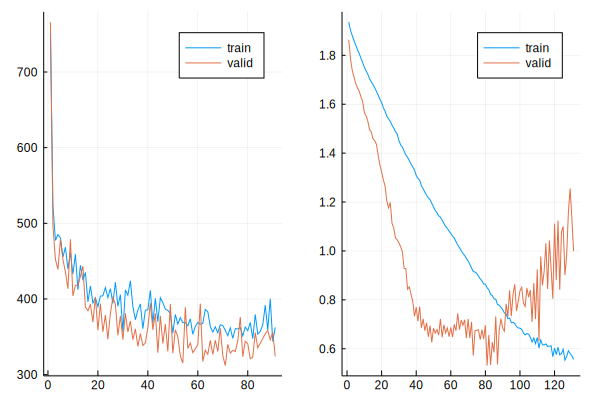

In [31]:
testmode!(m1)
#println("Optimal number of epochs:", optimal_epochs)
#println("Min loss val:", min_loss_val)
# Plot
plot([record_loss_sc_train],layout=2,label="train")
plot!(record_loss_sc_valid,label="valid")


plot!([record_loss_n_train],subplot=2,label="train")
plot!(record_loss_n_valid,subplot=2,label="valid")

#yscale("log")
#legend()

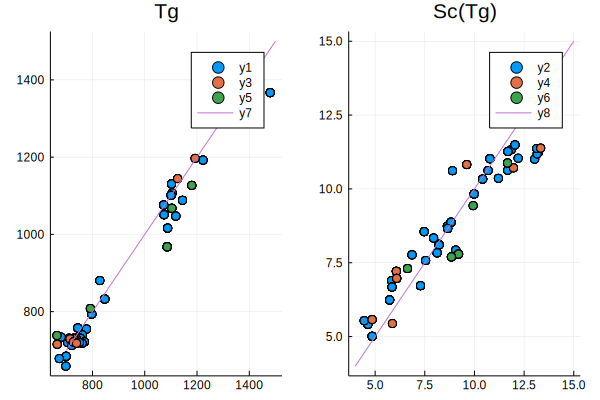

In [24]:
scatter([X_entropy_train_sc[12,:],X_entropy_train_sc[11,:]],
    [tg(X_entropy_train_sc).data[:],ScTg(X_entropy_train_sc).data[:]],
    layout=2, title=["Tg" "Sc(Tg)"])

scatter!([X_entropy_valid_sc[12,:],X_entropy_valid_sc[11,:]],
    [tg(X_entropy_valid_sc).data[:],ScTg(X_entropy_valid_sc).data[:]],
    layout=2, title=["Tg" "Sc(Tg)"])

scatter!([X_entropy_test_sc[12,:],X_entropy_test_sc[11,:]],
    [tg(X_entropy_test_sc).data[:],ScTg(X_entropy_test_sc).data[:]],
    layout=2, title=["Tg" "Sc(Tg)"])

plot!([[700;1500] [4;15]],[[700;1500] [4;15]])

0.951014611413714 (tracked)
0.6345205051937561 (tracked)


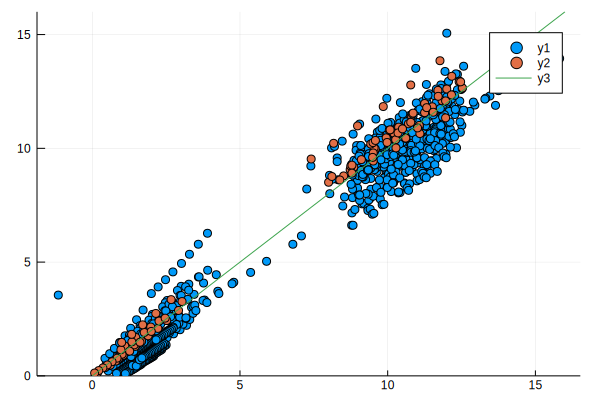

In [25]:
#x_tv_, y_tv_, T_tv_, ap_tv_, b_tv_, sc_tv_, tg_tv_ = prepare_datas(X_tv_sc,y_tv)



x_train_, y_train_, T_train_, ap_train_, b_train_, sc_train_, tg_train_ = prepare_datas(X_train_sc,y_train)
x_valid_, y_valid_, T_valid_, ap_valid_, b_valid_, sc_valid_, tg_valid_ = prepare_datas(X_valid_sc,y_valid)

println(loss_n(x_train_,T_train_, ap_train_, b_train_, y_train_))
println(loss_n(x_valid_,T_valid_, ap_valid_, b_valid_, y_valid_))

scatter(y_train_[:],
    model(x_train_,T_train_,ap_train_, b_train_).data[:],)
scatter!(y_valid_[:],
    model(x_valid_,T_valid_,ap_valid_, b_valid_).data[:],)
plot!([0.,16.],[0.,16.],ylim=(0,16))



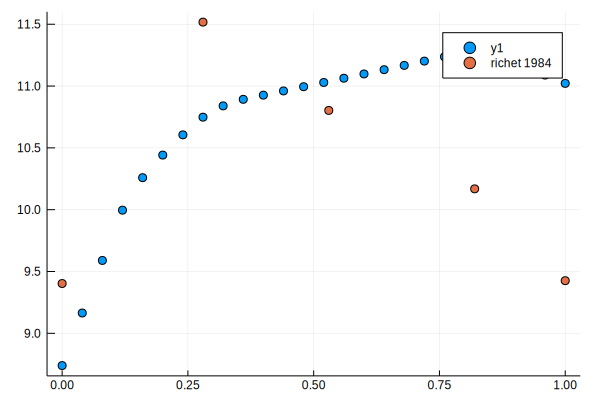

In [26]:
na2o = collect(0.:0.01:0.25)
k2o = 0.25.-na2o
sio2 = ones(size(na2o,1)).*0.75
al2o3 = zeros(size(na2o,1))
dummy = zeros(size(na2o,1))
T = ones(size(na2o,1)).*1000.0

X_visu_NKS = [sio2 al2o3 na2o k2o dummy dummy dummy dummy dummy T dummy dummy]'

X_visu_NKS_sc = copy(X_visu_NKS)

for i = 1:7
    X_visu_NKS_sc[i,:] = (X_visu_NKS_sc[i,:].- X_scaler_mean[i])./sqrt.(X_scaler_var[i]) 
end


scatter(X_visu_NKS[4,:]./(X_visu_NKS[3,:].+X_visu_NKS[4,:]),ScTg(X_visu_NKS_sc).data'[:])
scatter!([0,0.28,0.53,0.82,1.0],[32.91,40.31,37.81,35.59,32.99]./7.0.*2.0,label="richet 1984")

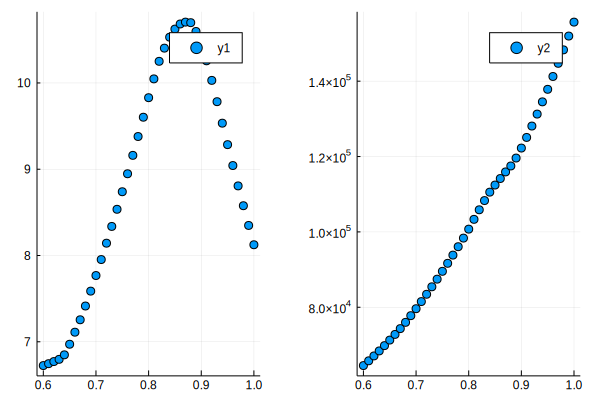

In [27]:
sio2 = collect(0.6:0.01:1.)
al2o3 = zeros(size(sio2,1))
na2o = 1.0.-sio2
k2o = zeros(size(sio2,1))
dummy = zeros(size(sio2,1))
T = ones(size(sio2,1)).*1000.0
X_visu_NS = [sio2 al2o3 na2o k2o dummy dummy dummy dummy dummy T dummy dummy]'

X_visu_NS_sc = copy(X_visu_NS)

for i = 1:7
    X_visu_NS_sc[i,:] = (X_visu_NS_sc[i,:].- X_scaler_mean[i])./sqrt.(X_scaler_var[i]) 
end
#x_visu_xaxis = X_visu_NKS[4,:]
#./(X_visu_NKS[3,:].+X_visu_NKS[4,:])'

scatter([X_visu_NS[1,:],X_visu_NS[1,:]],
    [ScTg(X_visu_NS_sc).data'[:],Be(X_visu_NS_sc).data'[:]],
layout=2)


# VISCOSITY

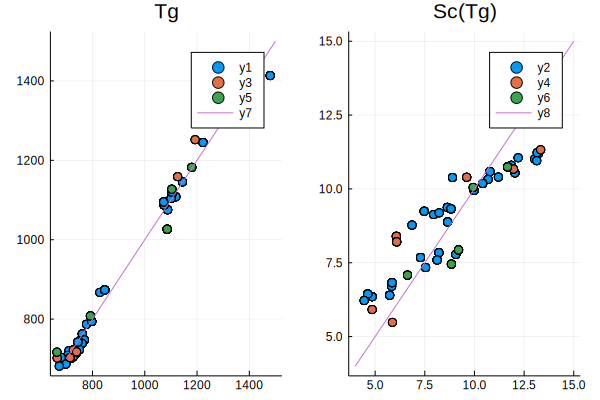

In [29]:
testmode!(m1)
scatter([X_entropy_train_sc[12,:],X_entropy_train_sc[11,:]],
    [tg(X_entropy_train_sc).data[:],ScTg(X_entropy_train_sc).data[:]],
    layout=2, title=["Tg" "Sc(Tg)"])

scatter!([X_entropy_valid_sc[12,:],X_entropy_valid_sc[11,:]],
    [tg(X_entropy_valid_sc).data[:],ScTg(X_entropy_valid_sc).data[:]],
    layout=2, title=["Tg" "Sc(Tg)"])

scatter!([X_entropy_test_sc[12,:],X_entropy_test_sc[11,:]],
    [tg(X_entropy_test_sc).data[:],ScTg(X_entropy_test_sc).data[:]],
    layout=2, title=["Tg" "Sc(Tg)"])

plot!([[700;1500] [4;15]],[[700;1500] [4;15]])

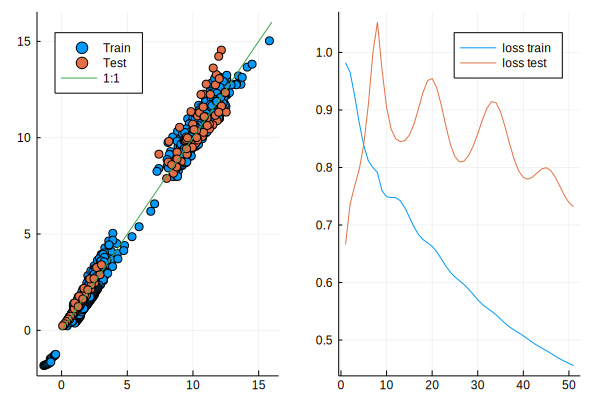

In [30]:
testmode!(m1)
#testmode!(m2)

x_train_, y_train_, T_train_, ap_train_, b_train_, sc_train_, tg_train_ = prepare_datas(X_train_sc,y_train)
x_valid_, y_valid_, T_valid_, ap_valid_, b_valid_, sc_valid_, tg_valid_ = prepare_datas(X_valid_sc,y_valid)

p1 = scatter(y_train_[:],
    model(x_train_,T_train_,ap_train_, b_train_).data[:],
    label="Train",legend=:topleft)
scatter!(y_valid_[:],
    model(x_valid_,T_valid_,ap_valid_, b_valid_).data[:],label="Test")
plot!([0.,16.],[0.,16.],label="1:1")


#p1 = scatter(y_tv[:],model(x_tv_,T_tv_,ap_tv_, b_tv_).data[:])

p2 = plot(collect(1:1:length(record_loss_n_train)),record_loss_n_train,label="loss train")

plot(p1,p2,layout=2)

plot!(collect(1:1:length(record_loss_n_valid)),record_loss_n_valid,subplot=2,label="loss test")
# plot(record_loss_n_train,label="valid")
# plot(record_loss_n_valid,label="train")
# yscale("log")
# legend()
#println(loss(x_train,T_train, ap_train, b_train, y_train))

In [31]:
print(minimum(record_loss_n_train))
print("\n")
print(minimum(record_loss_n_valid))

0.45564219232302844
0.6662156267403198

# Manual SAVE

In [124]:
# Manual save if needed
@save "./model/m1.bson" m1
@save "./model/Ae.bson" Ae

TypeError: TypeError: in Type, in parameter, expected Type, got Type{Vararg{Any,N} where N}

# Loading BEST model

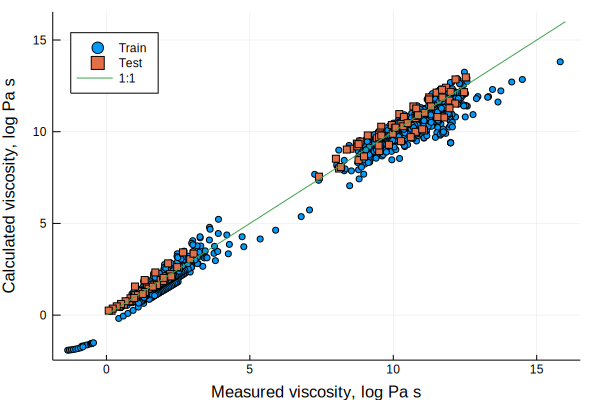

In [90]:
@load "./model/m1.bson" m1
@load "./model/Ae.bson" Ae

x_train_, y_train_, T_train_, ap_train_, b_train_, sc_train_, tg_train_ = prepare_datas(X_train_sc,y_train)
x_valid_, y_valid_, T_valid_, ap_valid_, b_valid_, sc_valid_, tg_valid_ = prepare_datas(X_valid_sc,y_valid)

p1 = scatter(y_train_[:],
    model(x_train_,T_train_,ap_train_, b_train_).data[:],
    label="Train",legend=:topleft,m=(3, :auto),
xlabel="Measured viscosity, log Pa s",
ylabel="Calculated viscosity, log Pa s")

scatter!(y_valid_[:],
    model(x_valid_,T_valid_,ap_valid_, b_valid_).data[:],label="Test",m=(3, :auto))
plot!([0.,16.],[0.,16.],label="1:1")